# Benchmark missing marker imputation (leave-one-out) for synthetic batches

In [1]:
import cytovi
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import os
import seaborn as sns
import matplotlib.pyplot as plt

/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_nan_layer' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/pyth

In [2]:
# read data
os.chdir('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/notebooks/')

figure_dir = '../figures/figure3/'

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["savefig.dpi"] = 300

In [3]:
# read data and subsample
adata = ad.read_h5ad('../data/2024-01-16_model_eval_multi_batch/2024-01-26_nunez_norm.h5ad')
adata = adata[adata.obs['batch']=='1'].copy()
adata = cytovi.pp.subsample(adata, n_obs = 50000)

# create a synthetic batch
batch_labels = np.array([0] * (adata.n_obs // 2) + [1] * (adata.n_obs // 2))
np.random.shuffle(batch_labels)
adata.obs['synth_batch'] = batch_labels
adata.obs['synth_batch'] = adata.obs['synth_batch'].astype('category')

# adata.write('../data/2024-02-20_hyperopt_flow_batch/2024-08-20_nunez_norm_50k_synth_batch.h5ad')

In [4]:
# read again
adata = ad.read_h5ad('../data/2024-02-20_hyperopt_flow_batch/2024-08-20_nunez_norm_50k_synth_batch.h5ad')

In [5]:
# load imputed data from disk
model_path = '/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/models/imputation_eval/2024-08-20_flow_50k_synth_batch_impute_'
imp_array_stack = np.load(f'{model_path}imputed_array.np.npy') # is protein x samples x cells

In [6]:
# restrict markers
rm_vars = ['FSC-H', 'SSC-H', 'SSC-B-A', 'SSC-B-H', 'CXCR3', 'PD1']
adata = adata[:, [var for var in adata.var_names if var not in rm_vars]].copy()

In [7]:
# Compute cv, std and cv for each marker
mean_sample = np.mean(imp_array_stack, axis=1)
std_sample = np.std(imp_array_stack, axis=1)
var_sample = np.var(imp_array_stack, axis=1)
cv_sample = std_sample / mean_sample

In [8]:
# prepare observed and predicted expr
observed = adata[adata.obs['synth_batch'] == 1, :].X.copy().T # is protein x cells

observed_exp = np.expand_dims(observed, 1)
observed_exp = np.repeat(observed_exp, imp_array_stack.shape[1], axis=1)

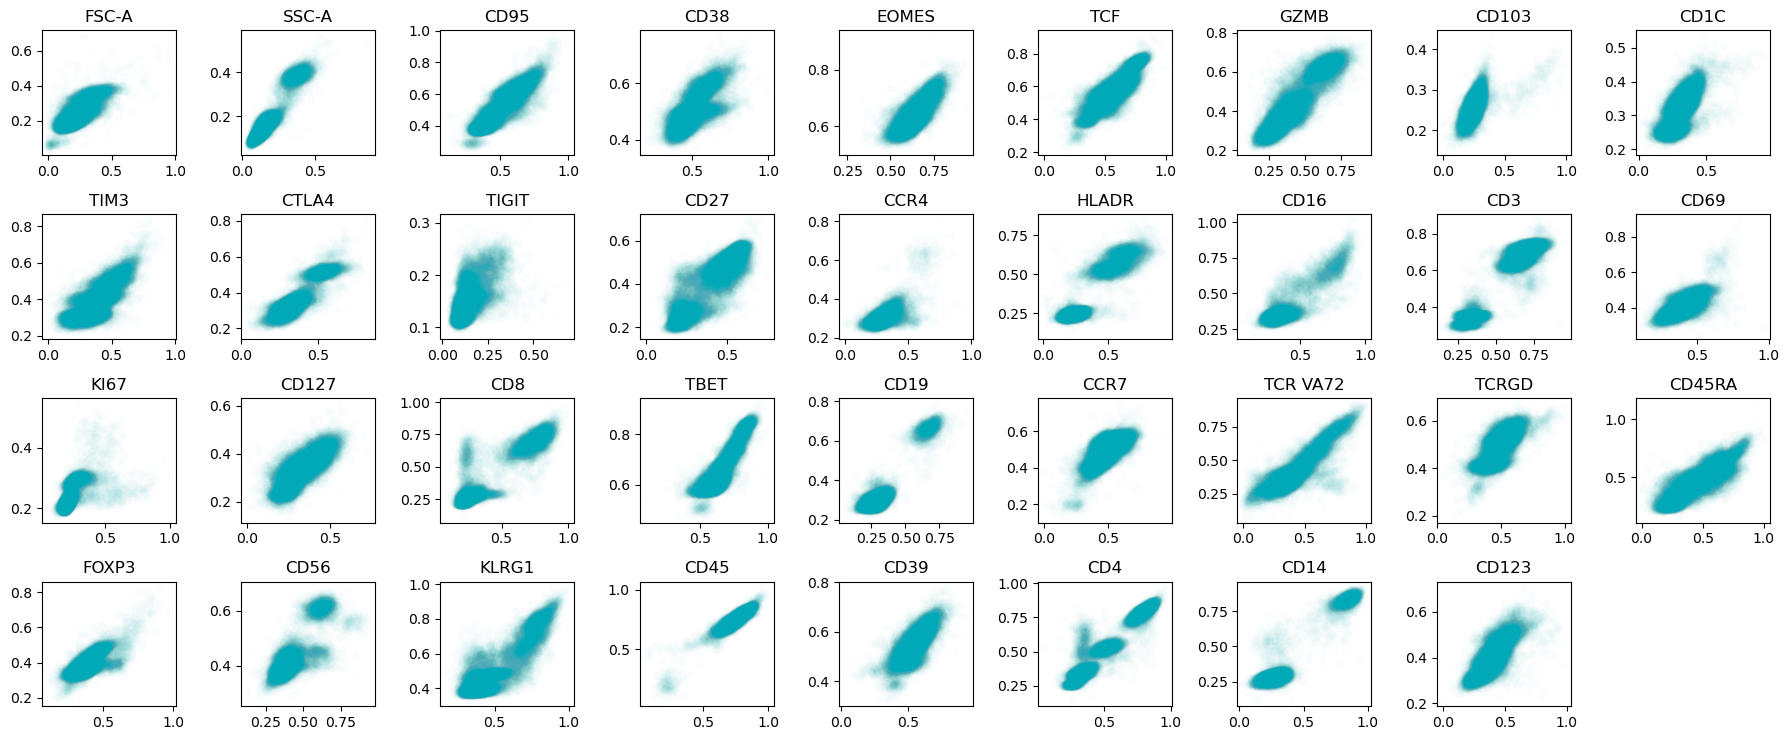

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

ncols = 9
total = adata.n_vars
rows = total // ncols + 1

fig = plt.figure(figsize=(ncols*2, 7.5))
it = 0

for marker in adata.var_names:
    ax = fig.add_subplot(rows, ncols, it+1)
    g = sns.scatterplot(x=observed[it], y=mean_sample[it], ax = ax, edgecolor='none', alpha=0.01, color = '#00A9B8')
    g.set_title(marker)
    g.set_ylabel('')
    g.set_xlabel('')
    it += 1

fig.tight_layout()
fig.savefig(f'{figure_dir}cytovi_imputations_scatter.png')

In [9]:
# export data for cycombine
expr = adata.layers['transformed']
var_names = adata.var_names
obs = adata.obs

expr_df = pd.DataFrame(expr, columns=var_names)
expr_df_scaled = pd.DataFrame(adata.layers['scaled'], columns=var_names)

# expr_df.to_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-07-05_aurora_imputation_expression.csv')
# expr_df_scaled.to_csv('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2025-08-26_aurora_imputation_expression_scaled.csv')
# obs.to_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-07-05_aurora_imputation_obs.csv')

In [10]:
# load cycombine imputations
predicted_cycombine_scaled = pd.read_csv('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2025-08-26_aurora_imputation_cycombine_imputed.csv', index_col=0)
predicted_cycombine_scaled.columns = var_names

In [ ]:
# inspect in scatter plot
ncols = 9
total = adata.n_vars
rows = total // ncols + 1

fig = plt.figure(figsize=(ncols*2, rows*2))
it = 0

for marker in adata.var_names:
    ax = fig.add_subplot(rows, ncols, it+1)
    g = sns.scatterplot(x=observed[it], y=predicted_cycombine_scaled[marker].values, ax = ax, edgecolor='none', alpha=0.01, color = '#00A9B8')
    g.set_title(marker)
    g.set_ylabel('')
    g.set_xlabel('')
    it += 1

fig.tight_layout()

In [11]:
# load CyTOFmerge imputations
predicted_cytofmerge = pd.read_csv('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2025-08-26_aurora_imputation_CyTOFmerge_imputed.csv', index_col=0)
predicted_cytofmerge.columns = var_names

# evaluate relationship between model uncertainty and prediction error

In [12]:
# compute error
pred_error = np.abs(imp_array_stack - observed_exp) # is protein x samples x cells
pred_error_mean = pred_error.mean(axis=1)

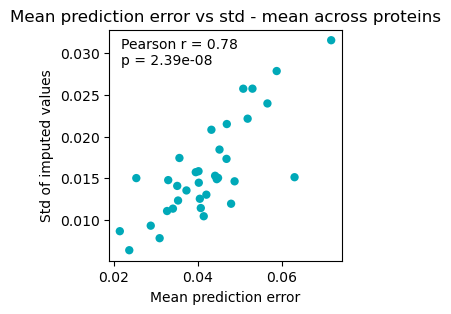

In [14]:
# aggregate on protein axis
from scipy.stats import pearsonr

pred_error_mean_protein = pred_error_mean.mean(axis=1)
std_sample_protein = std_sample.mean(axis=1)

r, p = pearsonr(pred_error_mean_protein, std_sample_protein)

plt.figure(figsize=(3, 3))
sns.scatterplot(x=pred_error_mean_protein, y=std_sample_protein, edgecolor='none', color = '#00A9B8')
plt.title('Mean prediction error vs std - mean across proteins')
plt.xlabel('Mean prediction error')
plt.ylabel('Std of imputed values')

# add text to plot
plt.text(0.05, 0.85, f'Pearson r = {r:.2f}\np = {p:.2e}', transform=plt.gca().transAxes)
plt.savefig(f'{figure_dir}mean_error_vs_std.png')
plt.savefig(f'{figure_dir}mean_error_vs_std.pdf')

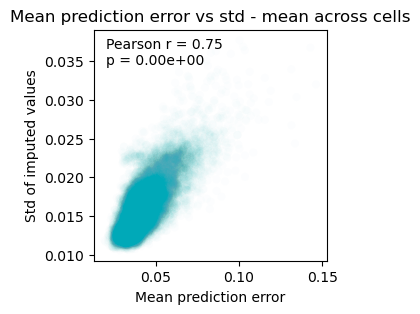

In [15]:
# aggregate on cell axis
pred_error_mean_cell = pred_error_mean.mean(axis=0)
std_sample_cell = std_sample.mean(axis=0)

r, p = pearsonr(pred_error_mean_cell, std_sample_cell)

plt.figure(figsize=(3, 3))
sns.scatterplot(x=pred_error_mean_cell, y=std_sample_cell, edgecolor='none', alpha = 0.01, color = '#00A9B8')
plt.title('Mean prediction error vs std - mean across cells')
plt.xlabel('Mean prediction error')
plt.ylabel('Std of imputed values')

# add text to plot
plt.text(0.05, 0.85, f'Pearson r = {r:.2f}\np = {p:.2e}', transform=plt.gca().transAxes)
plt.savefig(f'{figure_dir}mean_error_vs_std_cells.png')
plt.savefig(f'{figure_dir}mean_error_vs_std_cells.pdf')

# knn imputation as baseline method

In [ ]:
from sklearn.impute import KNNImputer

knn_imputation_dict = {}

for marker in adata.var_names:
    print(f'Processing {marker} now.')
    # mask marker
    adata_masked = cytovi.pp.mask_markers(adata, markers = marker, batch_key = 'synth_batch', nan_layer_registration = False, masked_batch=1)

    # build neighbor graph
    imputer = KNNImputer(n_neighbors = 10)
    adata_masked.layers['scaled'] = imputer.fit_transform(adata_masked.layers['scaled'])
    knn_imputation_dict[marker] = adata_masked[adata_masked.obs['synth_batch'] == 1, marker].layers['scaled'].copy().reshape(-1)


knn_imputation_df = pd.DataFrame.from_dict(knn_imputation_dict)

In [84]:
# # save on disk
# knn_imputation_df.to_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-08-02_aurora_imputation_KNN_imputed.csv')

In [13]:
# load again
knn_imputation_df = pd.read_csv('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-08-02_aurora_imputation_KNN_imputed.csv', index_col = 0)

In [14]:
# generate dfs
predicted = pd.DataFrame(mean_sample.T, columns=adata.var_names)
observed_df = pd.DataFrame(observed.T, columns=adata.var_names)

In [15]:
observed_df

,FSC-A,SSC-A,CD95,CD38,EOMES,TCF,GZMB,CD103,CD1C,TIM3,...,TCRGD,CD45RA,FOXP3,CD56,KLRG1,CD45,CD39,CD4,CD14,CD123
0,0.143795,0.115946,0.625867,0.418113,0.605177,0.606347,0.306499,0.248656,0.390970,0.311187,...,0.617593,0.200978,0.369753,0.425075,0.370196,0.829933,0.541088,0.829889,0.312910,0.252059
1,0.292008,0.120463,0.348010,0.464978,0.586344,0.617819,0.436784,0.213547,0.359303,0.265911,...,0.486353,0.590161,0.384001,0.404995,0.339401,0.764183,0.545614,0.782969,0.324523,0.457400
2,0.276781,0.215520,0.769993,0.450601,0.555047,0.481768,0.477132,0.289273,0.451493,0.300070,...,0.465279,0.308672,0.451450,0.412151,0.363823,0.809005,0.503789,0.873626,0.298518,0.318080
3,0.151429,0.148246,0.264493,0.557636,0.744871,0.324542,0.253957,0.270856,0.261401,0.326825,...,0.263727,0.404045,0.321203,0.390810,0.440905,0.251561,0.407538,0.356362,0.219967,0.599236
4,0.108549,0.061217,0.428174,0.345615,0.644279,0.426710,0.273256,0.198724,0.260094,0.294296,...,0.450132,0.383860,0.625856,0.416843,0.448633,0.746365,0.527438,0.684298,0.293396,0.204825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.261410,0.128534,0.429237,0.443162,0.603689,0.577272,0.320849,0.257541,0.356520,0.378964,...,0.533540,0.589516,0.337361,0.363377,0.397051,0.755143,0.573661,0.352132,0.294886,0.442936
24996,0.236370,0.128591,0.427291,0.516865,0.595623,0.684179,0.316422,0.234446,0.342168,0.389446,...,0.490575,0.526885,0.363501,0.401310,0.289727,0.797269,0.520567,0.789951,0.242000,0.395475
24997,0.203155,0.156647,0.708918,0.503105,0.743402,0.581951,0.299059,0.374682,0.305895,0.472717,...,0.684086,0.431562,0.388389,0.347655,0.738605,0.855346,0.560546,0.381937,0.277679,0.412201
24998,0.319310,0.136303,0.549704,0.528990,0.699615,0.615724,0.534825,0.205134,0.361000,0.078229,...,0.852990,0.314244,0.367784,0.418830,0.796138,0.806172,0.588427,0.348642,0.334180,0.387258


In [16]:
# compute summary stats
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import pearsonr, spearmanr, wasserstein_distance

summary_dict = {'CytoVI': {}, 'Cycombine': {}, 'KNN': {}, 'CyTOFmerge': {}}

for marker in adata.var_names:
    # CytoVI
    observed_marker = observed_df[marker].values
    predicted_marker = predicted[marker].values

    mae_metric = mae(observed_marker, predicted_marker)
    pearsonr_metric = pearsonr(observed_marker, predicted_marker)
    spearmanr_metric = spearmanr(observed_marker, predicted_marker)
    wasserstein_metric = wasserstein_distance(observed_marker, predicted_marker)

    summary_dict['CytoVI'][marker] = {
        'mae': mae_metric,
        'pearsonr': pearsonr_metric[0],
        'spearmanr': spearmanr_metric[0],
        'wasserstein': wasserstein_metric

    }

    # KNN
    predicted_marker = knn_imputation_df[marker].values

    mae_metric = mae(observed_marker, predicted_marker)
    pearsonr_metric = pearsonr(observed_marker, predicted_marker)
    spearmanr_metric = spearmanr(observed_marker, predicted_marker)
    wasserstein_metric = wasserstein_distance(observed_marker, predicted_marker)

    summary_dict['KNN'][marker] = {
        'mae': mae_metric,
        'pearsonr': pearsonr_metric[0],
        'spearmanr': spearmanr_metric[0],
        'wasserstein': wasserstein_metric
    }


    # CyTOFmerge
    predicted_marker = predicted_cytofmerge[marker].values

    mae_metric = mae(observed_marker, predicted_marker)
    pearsonr_metric = pearsonr(observed_marker, predicted_marker)
    spearmanr_metric = spearmanr(observed_marker, predicted_marker)
    wasserstein_metric = wasserstein_distance(observed_marker, predicted_marker)

    summary_dict['CyTOFmerge'][marker] = {
        'mae': mae_metric,
        'pearsonr': pearsonr_metric[0],
        'spearmanr': spearmanr_metric[0],
        'wasserstein': wasserstein_metric
    }

    # cyCombine
    predicted_marker = predicted_cycombine_scaled[marker].values

    # handle nans: note if uncertain cycombine does not return values but nans
    observed_marker = observed_marker[~np.isnan(predicted_marker)]
    predicted_marker = predicted_marker[~np.isnan(predicted_marker)]


    mae_metric = mae(observed_marker, predicted_marker)
    pearsonr_metric = pearsonr(observed_marker, predicted_marker)
    spearmanr_metric = spearmanr(observed_marker, predicted_marker)
    wasserstein_metric = wasserstein_distance(observed_marker, predicted_marker)

    summary_dict['Cycombine'][marker] = {
        'mae': mae_metric,
        'pearsonr': pearsonr_metric[0],
        'spearmanr': spearmanr_metric[0],
        'wasserstein': wasserstein_metric
    }



summary_df = pd.DataFrame.from_dict(summary_dict)

In [17]:
summary_dict['CytoVI'] = pd.DataFrame(summary_dict['CytoVI'])
summary_dict['CytoVI'] = summary_dict['CytoVI'].reset_index().melt(id_vars='index', var_name = 'marker')
summary_dict['CytoVI']['method'] = 'CytoVI'

summary_dict['KNN'] = pd.DataFrame(summary_dict['KNN'])
summary_dict['KNN'] = summary_dict['KNN'].reset_index().melt(id_vars='index', var_name = 'marker')
summary_dict['KNN']['method'] = 'KNN'

summary_dict['CyTOFmerge'] = pd.DataFrame(summary_dict['CyTOFmerge'])
summary_dict['CyTOFmerge'] = summary_dict['CyTOFmerge'].reset_index().melt(id_vars='index', var_name = 'marker')
summary_dict['CyTOFmerge']['method'] = 'CyTOFmerge'

summary_dict['Cycombine'] = pd.DataFrame(summary_dict['Cycombine'])
summary_dict['Cycombine'] = summary_dict['Cycombine'].reset_index().melt(id_vars='index', var_name = 'marker')
summary_dict['Cycombine']['method'] = 'Cycombine'


summary_df = pd.concat([summary_dict['CytoVI'], summary_dict['Cycombine'], summary_dict['KNN'], summary_dict['CyTOFmerge']])
summary_df

,index,marker,value,method
0,mae,FSC-A,0.042826,CytoVI
1,pearsonr,FSC-A,0.757859,CytoVI
2,spearmanr,FSC-A,0.729137,CytoVI
3,wasserstein,FSC-A,0.021632,CytoVI
4,mae,SSC-A,0.020157,CytoVI
...,...,...,...,...
135,wasserstein,CD14,0.022355,CyTOFmerge
136,mae,CD123,0.047679,CyTOFmerge
137,pearsonr,CD123,0.786675,CyTOFmerge
138,spearmanr,CD123,0.775549,CyTOFmerge


In [18]:
# compute prediction errors
pred_error_cytovi = (observed_df - predicted).melt(var_name='marker')
pred_error_cytovi['method'] = 'CytoVI'

pred_error_KNN = (observed_df - knn_imputation_df).melt(var_name='marker')
pred_error_KNN['method'] = 'KNN'

pred_error_cycombine = (observed_df - predicted_cycombine_scaled).melt(var_name='marker')
pred_error_cycombine['method'] = 'Cycombine'

pred_error_cytofmerge = (observed_df - predicted_cytofmerge).melt(var_name='marker')
pred_error_cycombine['method'] = 'CyTOFmerge'

pred_error_comb = pd.concat([pred_error_cytovi, pred_error_cycombine, pred_error_KNN, pred_error_cytofmerge])

In [ ]:
# reformat order of summary_df
marker_order = [*summary_df[(summary_df['method']=='CytoVI') & (summary_df['index']=='mae')].sort_values('value')['marker']]
summary_df_pivot = summary_df.pivot_table(index='index', columns=['marker', 'method'], values='value')
columns = summary_df_pivot.columns
new_columns = [(marker, method) for marker in marker_order for method in summary_df['method'].unique()]
summary_df_pivot = summary_df_pivot.reindex(columns=new_columns)

summary_df_pivot.update(summary_df_pivot.astype(float))
summary_df_pivot.update(summary_df_pivot.applymap('{:,.2f}'.format))

/tmp/ipykernel_1494646/3724868201.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


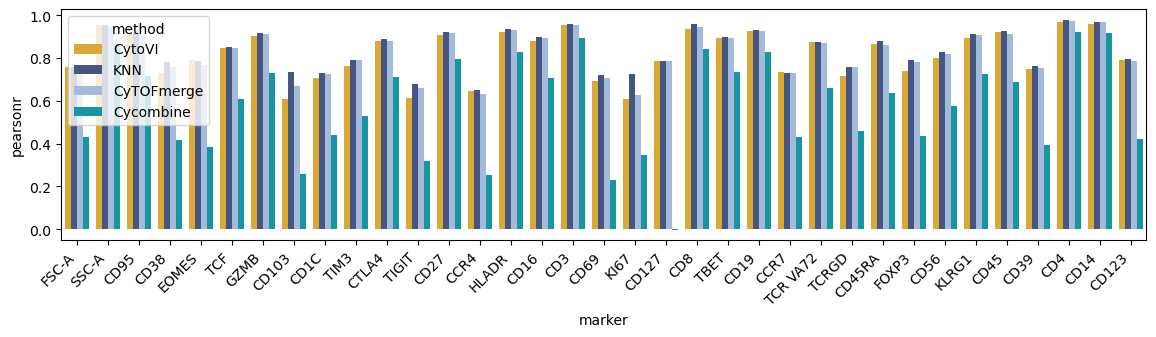

In [20]:
# plot pearson corr for all markers
method_cols = {'CytoVI': '#F6B319','Cycombine': '#00A9B8', 'KNN': '#3A528B', 'CyTOFmerge': '#9BB8E3'}
hue_order = ['CytoVI', 'KNN', 'CyTOFmerge', 'Cycombine']

summary_df_pearson = summary_df[summary_df['index']=='pearsonr'].drop('index', axis = 1)

fig, ax = plt.subplots(figsize=(14, 3))
sns.barplot(data = summary_df_pearson, x = 'marker', y = 'value', hue = 'method', order = var_names, hue_order = hue_order, ax = ax, palette = method_cols)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('pearsonr')
fig.savefig(f'{figure_dir}barplot_pearsonr_imputation_benchmark.pdf')

/tmp/ipykernel_1494646/3360135658.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


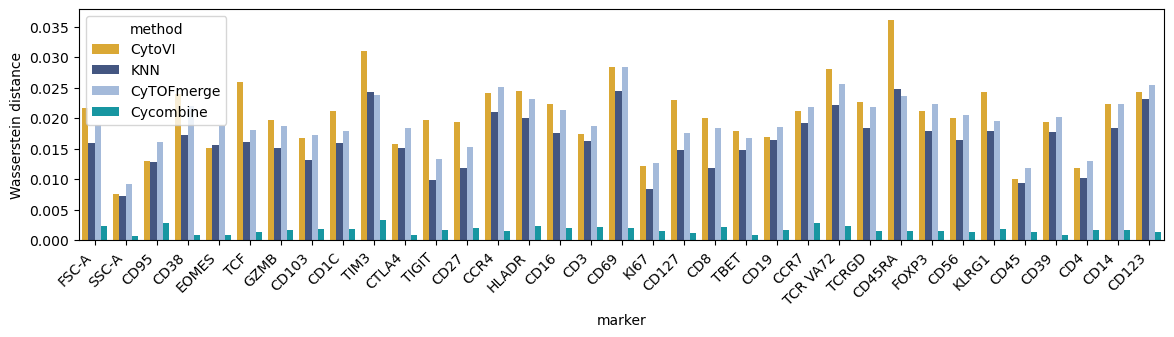

In [21]:
# plot EMD for all markers
summary_df_wasserstein = summary_df[summary_df['index']=='wasserstein'].drop('index', axis = 1)

fig, ax = plt.subplots(figsize=(14, 3))
sns.barplot(data = summary_df_wasserstein, x = 'marker', y = 'value', hue = 'method', order = var_names, hue_order = hue_order, ax = ax, palette = method_cols)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('Wasserstein distance')
fig.savefig(f'{figure_dir}barplot_wasserstein_imputation_benchmark.pdf')

/tmp/ipykernel_1494646/2463368433.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


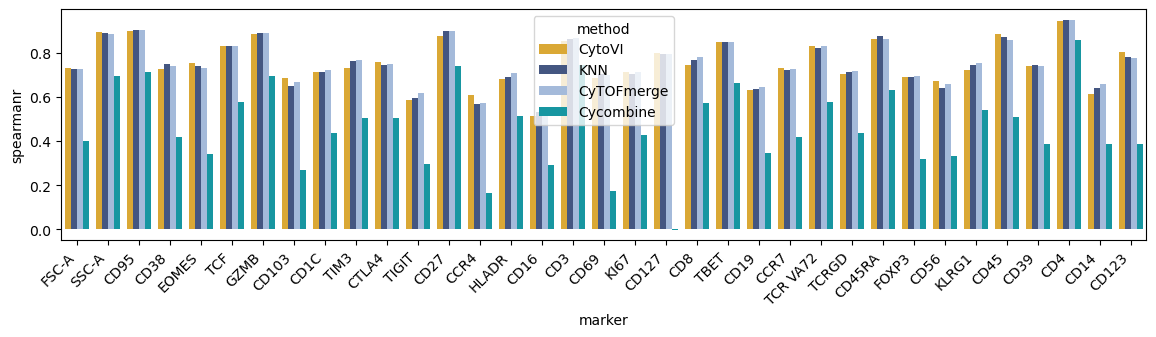

In [22]:
# plot pearson corr for all markers
summary_df_spearman = summary_df[summary_df['index']=='spearmanr'].drop('index', axis = 1)

fig, ax = plt.subplots(figsize=(14, 3))
sns.barplot(data = summary_df_spearman, x = 'marker', y = 'value', hue = 'method', order = var_names, hue_order = hue_order, ax = ax, palette = method_cols)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('spearmanr')
fig.savefig(f'{figure_dir}barplot_spearmanr_imputation_benchmark.pdf')

# Analyze impact of fluorophore brightness

In [23]:
# read fluorophore brightness and dynamic range per channel
fluorophore_brightness = pd.read_csv('../data/raw/Spectral flow/Nunez/For Chiquito/t_cell_panel_antibodies_final.csv', index_col=0)

# Coerce to float (anything non-numeric -> NaN)
fluorophore_brightness['Brightness'] = pd.to_numeric(
    fluorophore_brightness['Brightness'], errors='coerce'
)


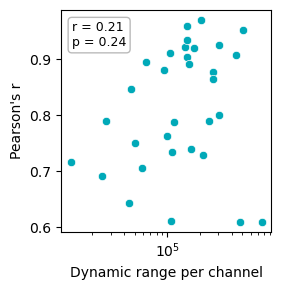

In [26]:
summary_df_meta = summary_df.merge(
    fluorophore_brightness[['Fluorochrome','Antigen','Brightness','PnR']],
    how='left',
    left_on='marker',
    right_on='Antigen'
).drop(columns=['Antigen'])

pearson_cytovi = summary_df_meta[(summary_df_meta['index']=='pearsonr') & (summary_df_meta['method']=='CytoVI')]

# ensure numeric & drop non-finite / non-positive PnR (needed for log)
dfc = pearson_cytovi[['PnR','value']].apply(pd.to_numeric, errors='coerce').copy()
dfc = dfc.replace([np.inf, -np.inf], np.nan).dropna()
dfc = dfc[dfc['PnR'] > 0]

# Pearson r between log10(PnR) and marker-wise Pearson r
r, p = pearsonr(np.log10(dfc['PnR'].to_numpy()), dfc['value'].to_numpy())

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=pearson_cytovi, x='PnR', y='value', color='#00A9B8', ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Dynamic range per channel')
ax.set_ylabel("Pearson's r")

# annotate in axes coords
ax.text(
    0.05, 0.95, f"r = {r:.2f}\np = {p:.2g}",
    transform=ax.transAxes, va='top', ha='left',
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='0.7', alpha=0.9), fontsize=9
)

fig.tight_layout()
fig.savefig(f'{figure_dir}Scatter_CytoVI_imputation_pearsonr_vs_dynamic_range.pdf')


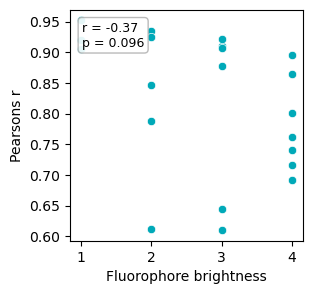

In [47]:
# Pearson r between brightness and marker-wise Pearson r
dfc = pearson_cytovi[['Brightness','value']].apply(pd.to_numeric, errors='coerce').copy()
dfc = dfc.loc[~dfc['Brightness'].isna(),]

r, p = pearsonr(dfc['Brightness'].to_numpy(), dfc['value'].to_numpy())

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=pearson_cytovi, x='Brightness', y='value', color = '#00A9B8', ax = ax)

ax.text(
    0.05, 0.95, f"r = {r:.2f}\np = {p:.2g}",
    transform=ax.transAxes, va='top', ha='left',
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='0.7', alpha=0.9), fontsize=9
)

ax.set_xlabel('Fluorophore brightness')
ax.set_ylabel('Pearsons r')
fig.savefig(f'{figure_dir}Scatter_CytoVI_imputation_pearsonr_vs_fluorophore_brightness.pdf')

# Convert to binary classification task

In [48]:
bin_markers = ['FSC-A', 'SSC-A', 'CD95', 'GZMB', 'CD103', 'CD1C', 'CTLA4', 'CD27', 'HLADR', 'CD16', 'CD3', 
                'KI67', 'CD8', 'TBET', 'CD19', 'TCRGD', 'CD45RA', 'FOXP3', 'CD56', 'KLRG1', 'CD45', 'CD4', 'CD14', 'CD123']

In [49]:
# fit two component GMM
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score 


stats_dict = {'CytoVI': {},'KNN': {}, 'Cycombine': {}, 'CyTOFmerge': {}}
for marker in bin_markers:
    X = observed_df[marker].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(X)
    observed_class = gmm.predict(X)

    # check whether the class is positive
    observed_class = observed_class == np.argmax(gmm.means_)

    X = predicted[marker].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(X)
    predicted_class = gmm.predict(X)
    predicted_class = predicted_class == np.argmax(gmm.means_)

    accuracy = accuracy_score(observed_class, predicted_class)
    precision = precision_score(observed_class, predicted_class)
    recall = recall_score(observed_class, predicted_class)
    f1 = f1_score(observed_class, predicted_class)
    auc_class = roc_auc_score(observed_class, predicted_class)
    stats_dict['CytoVI'][marker] = {'accuracy': accuracy, 'precision': precision, 'recall': recall,
                'f1': f1, 'auc_class': auc_class}


    # KNN
    X = knn_imputation_df[marker].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(X)
    predicted_class = gmm.predict(X)
    predicted_class = predicted_class == np.argmax(gmm.means_)

    accuracy = accuracy_score(observed_class, predicted_class)
    precision = precision_score(observed_class, predicted_class)
    recall = recall_score(observed_class, predicted_class)
    f1 = f1_score(observed_class, predicted_class)
    auc_class = roc_auc_score(observed_class, predicted_class)
    stats_dict['KNN'][marker] = {'accuracy': accuracy, 'precision': precision, 'recall': recall,
                'f1': f1, 'auc_class': auc_class}

    # CyTOFmerge
    X = predicted_cytofmerge[marker].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(X)
    predicted_class = gmm.predict(X)
    predicted_class = predicted_class == np.argmax(gmm.means_)

    accuracy = accuracy_score(observed_class, predicted_class)
    precision = precision_score(observed_class, predicted_class)
    recall = recall_score(observed_class, predicted_class)
    f1 = f1_score(observed_class, predicted_class)
    auc_class = roc_auc_score(observed_class, predicted_class)
    stats_dict['CyTOFmerge'][marker] = {'accuracy': accuracy, 'precision': precision, 'recall': recall,
                'f1': f1, 'auc_class': auc_class}

    # repeat for cycombine
    observed_marker = observed_df[marker].values.reshape(-1, 1)
    predicted_marker = predicted_cycombine_scaled[marker].values.reshape(-1, 1)
    observed_marker = observed_marker[~np.isnan(predicted_marker)].reshape(-1, 1)
    predicted_marker = predicted_marker[~np.isnan(predicted_marker)].reshape(-1, 1)

    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(observed_marker)
    observed_class = gmm.predict(observed_marker)
    observed_class = observed_class == np.argmax(gmm.means_)

    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(predicted_marker)
    predicted_class = gmm.predict(predicted_marker)
    predicted_class = predicted_class == np.argmax(gmm.means_)

    accuracy = accuracy_score(observed_class, predicted_class)
    precision = precision_score(observed_class, predicted_class)
    recall = recall_score(observed_class, predicted_class)
    f1 = f1_score(observed_class, predicted_class)
    auc_class = roc_auc_score(observed_class, predicted_class)
    stats_dict['Cycombine'][marker] = {'accuracy': accuracy, 'precision': precision, 'recall': recall,
                'f1': f1, 'auc_class': auc_class}

In [55]:
pd.DataFrame(stats_dict['CytoVI'])

,index,marker,value,method
0,accuracy,FSC-A,0.844320,CytoVI
1,precision,FSC-A,0.551428,CytoVI
2,recall,FSC-A,0.750994,CytoVI
3,f1,FSC-A,0.635921,CytoVI
4,auc_class,FSC-A,0.807972,CytoVI
...,...,...,...,...
115,accuracy,CD123,0.825560,CytoVI
116,precision,CD123,0.670257,CytoVI
117,recall,CD123,0.846124,CytoVI
118,f1,CD123,0.747992,CytoVI


In [ ]:
# reformat stats
stats_dict['CytoVI'] = pd.DataFrame(stats_dict['CytoVI'])
stats_dict['CytoVI'] = stats_dict['CytoVI'].reset_index().melt(id_vars='index', var_name = 'marker')
stats_dict['CytoVI']['method'] = 'CytoVI'

stats_dict['KNN'] = pd.DataFrame(stats_dict['KNN'])
stats_dict['KNN'] = stats_dict['KNN'].reset_index().melt(id_vars='index', var_name = 'marker')
stats_dict['KNN']['method'] = 'KNN'

stats_dict['CyTOFmerge'] = pd.DataFrame(stats_dict['CyTOFmerge'])
stats_dict['CyTOFmerge'] = stats_dict['CyTOFmerge'].reset_index().melt(id_vars='index', var_name = 'marker')
stats_dict['CyTOFmerge']['method'] = 'CyTOFmerge'

stats_dict['Cycombine'] = pd.DataFrame(stats_dict['Cycombine'])
stats_dict['Cycombine'] = stats_dict['Cycombine'].reset_index().melt(id_vars='index', var_name = 'marker')
stats_dict['Cycombine']['method'] = 'Cycombine'

bin_stat_df = pd.concat([stats_dict['CytoVI'], stats_dict['Cycombine'], stats_dict['KNN'], stats_dict['CyTOFmerge']])
bin_stat_df

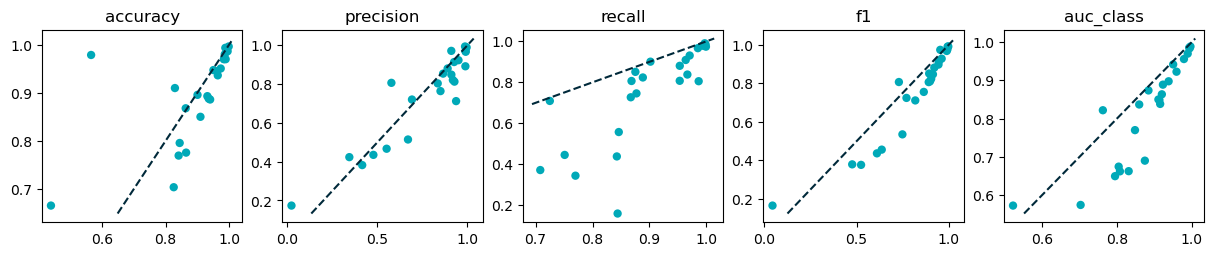

In [59]:
# compare binary predictive power of cycombine to cytovi
it = 0
fig, axes = plt.subplots(1, 5, figsize = (5*3, 2.5))
for metric in bin_stat_df['index'].unique():
    matric_df = bin_stat_df[bin_stat_df['index']==metric].pivot_table(index='marker', columns=['method'], values='value')

    g = sns.scatterplot(x=matric_df['CytoVI'].values, y=matric_df['Cycombine'].values, edgecolor='none', color = '#00A9B8', ax = axes[it])
    g.set_title(metric)
    x0, x1 = g.get_xlim()
    y0, y1 = g.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.plot(lims, lims, color="#00293A", linestyle="dashed", label="x=y")
    g.set_ylabel('')
    g.set_xlabel('')
    it += 1

fig.savefig(f'{figure_dir}scatter_plot_imputation_binary_prediction_cytoVI_cycombine.pdf')

/tmp/ipykernel_1494646/1774392800.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


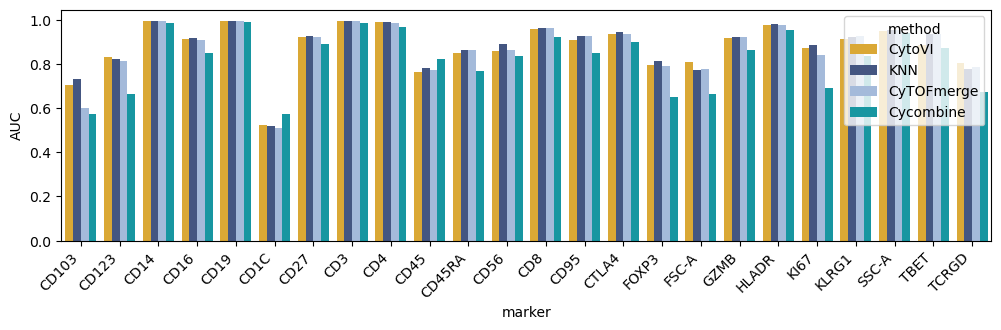

In [60]:
# plot AUCs in bar graphs
auc_long = matric_df.T.reset_index().melt(id_vars = 'method')
order = [*auc_long[auc_long['method']=='CytoVI'].sort_values('value', ascending = False)['marker']]
fig, ax = plt.subplots(figsize=(12, 3))
sns.barplot(data = auc_long, x = 'marker', y = 'value', hue = 'method', hue_order = hue_order, ax = ax, palette = method_cols)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('AUC')

fig.savefig(f'{figure_dir}barplot_imputation_binary_prediction_AUC.pdf')